<a href="https://colab.research.google.com/github/Haytam258/CustomDatasetWithEfficientNet/blob/main/CustomDataSets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### On this chapter, we'll be working with custom data (as in, not part of the datasets of pytorch)

Generally speaking, if you're dealing with images or vision-type problems, you use **Torchvision**.
If you're dealing with text, you use **TorchText**.
If you're dealing with audio, you use **TorchAudio**.
If you're dealing with recommendations, you use **TorchRec**.
Each of these Librairies have their specific datasets and dataloader functions. (Which can be found in the documentation)

In [1]:
# All the basic imports that would be used later
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import requests
import tqdm.auto as tqdm
from pathlib import Path
from torchvision import datasets, transforms

In [2]:
# Let's see the download for mlxtend 0.19.0 or higher
try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1] >= 19), "version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import mlxtend
  print(f"Version of mlxtend is {mlxtend.__version__} ")

     |████████████████████████████████| 419 kB 4.8 MB/s 
     |████████████████████████████████| 1.3 MB 42.4 MB/s 
Version of mlxtend is 0.20.0 


In [3]:
# Let's get Daniel bourke's helper_functions (our instructor):
if Path("helper_functions.py").is_file():
  print("Already exists")
else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/food-not-food/main/utils/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    print("Downloading the file and writing ...")
    f.write(request.content)

In [4]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get Data 
We're building a Food vision app (pizza or sushi or steak) 
We'll be using a subset of the Kaggle dataset for Food101 (that has 101 classes, 1000 images per class, 750 for training and 250 for testing).

We start small. Our dataset starts with 3 classes of food and only 10% of the images.

Why this ?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
The whole point is to speed up how fast you can experiment

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists, Skipping download...")
else :
  print(f"Creating a new directory {image_path}")
  image_path.mkdir(parents = True, exist_ok = True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading the file ...")
  f.write(request.content)

# Unzip the data file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)


Creating a new directory data/pizza_steak_sushi
Unzipping pizza, steak and sushi data...


## Becoming one with the data (data preparation and data exploration)

In [6]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.


In [7]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"


### Visualize an image

Let's write some code to :
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's Pillow (also known as PIL Python Imaging Library)
5. We'll then show the image and print metadata

data/pizza_steak_sushi/test/sushi/3837522.jpg
sushi
Random image path : data/pizza_steak_sushi/test/sushi/3837522.jpg
Image class : sushi
Image height : 512
Image width : 512


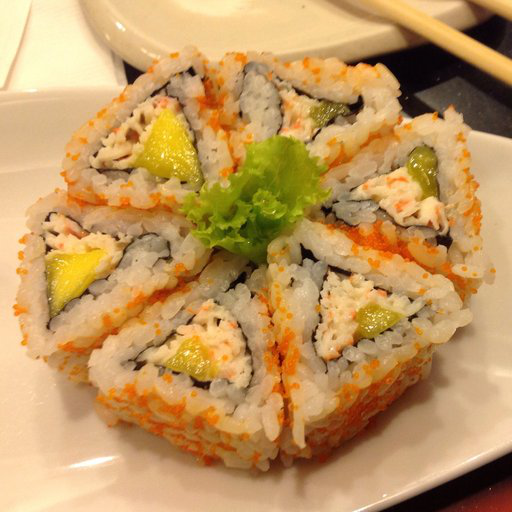

In [8]:
# Let's write some code in order to visualize a random image
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths (glob is a function that will grab all the paths that fit a certain pattern)
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open the image using PIL (we can also use Pytorch's built-in function), if the image is corrupted then it'll throw an error so it's a good way to clean up your data
img = Image.open(random_image_path)

# 5. Print the metadata
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

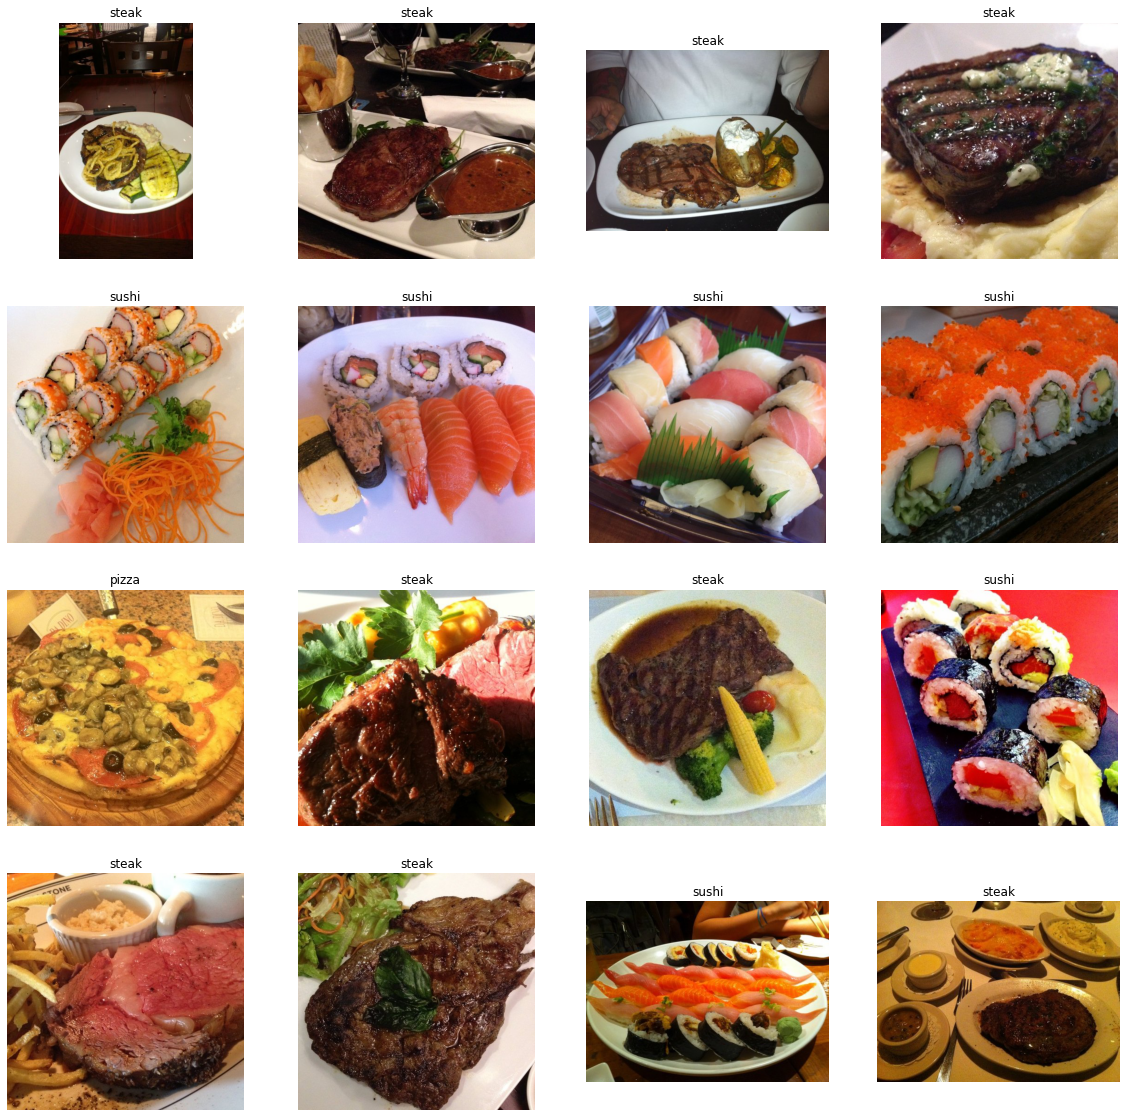

In [9]:
import matplotlib.image as mpimg
plt.figure(figsize=(20,20))
cols = 4
rows = 4
for i in range(1, cols*rows + 1):
  random_image_path = random.choice(list(image_path.glob("*/*/*.jpg")))
  random_image_class = random_image_path.parent.stem
  plt.subplot(cols, rows, i)
  plt.imshow(mpimg.imread(random_image_path))
  plt.title(random_image_class)
  plt.axis(False)

A different way of visualizing images using Numpy and pyplot (turning image into np.array)

(-0.5, 511.5, 511.5, -0.5)

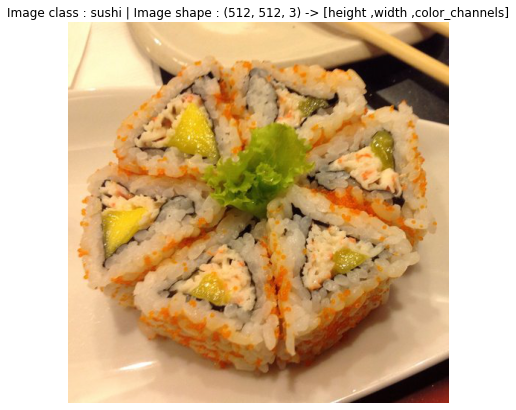

In [10]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height ,width ,color_channels]")
plt.axis(False)

### Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset`and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader.


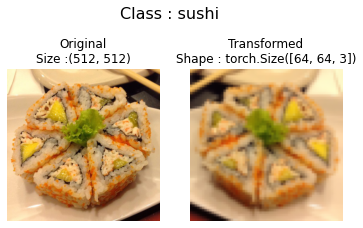

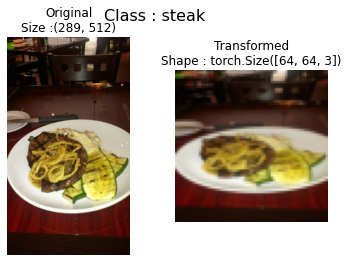

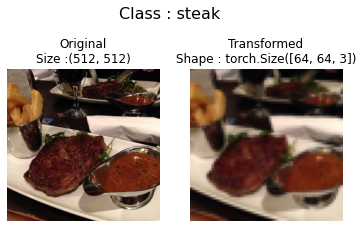

In [11]:
# Transform data with torchvision.tranforms

data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.tensor
    transforms.ToTensor()
])

data_transform(img)

def plot_transformed_images(image_paths : list, transform, n = 3, seed = None):
  """Selects random images from a path of images and loads/transforms them then plots 
  the original vs the transformed version"""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize :{f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # From (C,H,W) -> (H,W,C) C : Color channels, H: Height, W: Width
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape : {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class : {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_paths = image_path_list,
                        transform= data_transform,
                        n = 3,
                        seed = 42)

### Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`


In [12]:
# Use ImageFolder to create dataset
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform = None) # a transfrom for the labels/targets

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

# Get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as a dict
class_dict = train_data.class_to_idx

In [14]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
# Index on the train_data Dataset to get a single image and label
img , label = train_data[0][0], train_data[0][1]

print(f"Image tensor : \n {img}")
print(f"Image shape : {img.shape}")
print(f"Image datatype : {img.dtype}")
print(f"Image label : {label}")
print(f"Label datatype : {type(label)}")

Image tensor : 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0

Original shape :torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute : torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

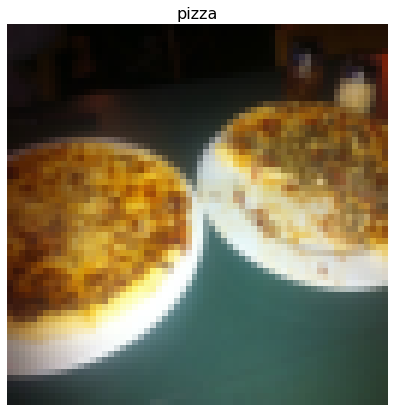

In [16]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape :{img.shape} -> [color_channels, height, width]")
print(f"Image permute : {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16)

### Turn loaded images into DataLoaders

A DataLoader is going to help us turn out Datasets into iterables and we can customize the batch_size so our model can see batch_size images at a time.

In [17]:
import os
# Turn train and test datasets into DataLoader, the more workers the better
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = 1,
                              num_workers = 1, # we can use os.cpu_count() to use as many CPU cores as we want
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 1,
                             num_workers = 1,
                             shuffle = False)

In [18]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape :{img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape : {label.shape}")

Image shape :torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape : torch.Size([1])


### Option 2: Loading Image Data with a custom Dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionnary from the Dataset

Pros: 
* Can create a dataset our of almost anything
* Not limited to PyTorch pre-built Dataset functions

Cons:
* Even though you could create Dataset out of almost anything, it doesn't mean it will work...
* Using a custom Dataset often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `torch.utils.data.Dataset`

In [19]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [20]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally in standard image classification format).
2. Raise an error if class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the calss names into a dict and a a list and return them.

In [21]:
# Setup path for target directory

target_directory = train_dir
print(f"Target dir : {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])

Target dir : data/pizza_steak_sushi/train


In [22]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

In [23]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class folder names in a target directory """
  # Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory} ... please check the file structure")

  # Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * Paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to load images `load_images()`
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [24]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform = None):

    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    # Setup transforms
    self.transform = transform

    # Create classes and class_to_idx attribute
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index : int) -> Image.Image:
    """Opens an image via a path and returns it."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """Returns the total number of samples"""
    return len(self.paths)

  # 6. Overwrite the __getitem___() to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data and label (X,y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects path in format : data_folder / class_name / image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else :
      return img, class_idx # return untransformed image and label

In [25]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize(size = (64,64)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ToTensor()
    ]
)

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [26]:
# Test our ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

len(train_data), len(train_data_custom)
train_data_custom.classes
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [27]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset

print(train_data_custom.classes == train_data.classes)


True


### Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [28]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n : int = 10,
                          display_shape : bool = True,
                          seed: int = None):
  
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larget than 10, setting to 10 and removing shape display")
  
  # 3. Set the random seed for reproducibility
  if seed:
    random.seed(seed)
  
  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5. Setup plot
  plt.figure(figsize = (16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class : {classes[targ_label]}"
      if display_shape:
        title = title + f"n\shape : {targ_image_adjust.shape}"
    plt.title(title)

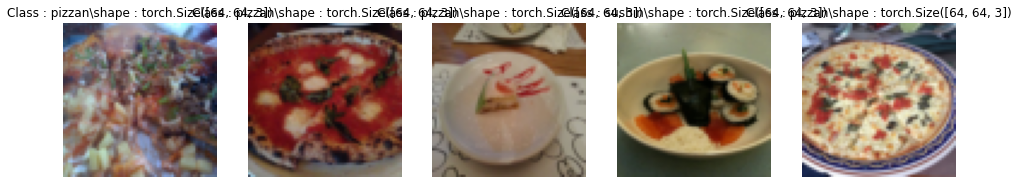

In [29]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

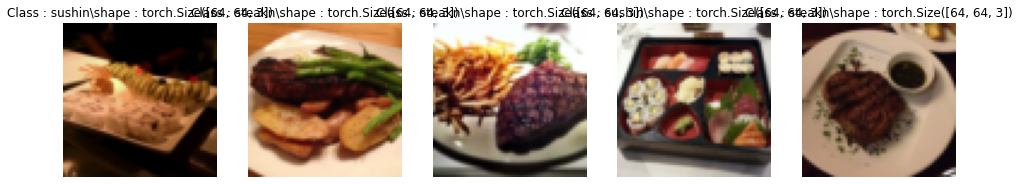

In [30]:
# Display random images from the ImagesFolderCustom Dataset
display_random_images(train_data_custom,
                      n = 5,
                      classes = class_names,
                      seed = 42)

### Turn custom loaded images into DataLoaders

In [31]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = 32,
                                     shuffle = True, 
                                     num_workers = 0)

test_dataloader_custom = DataLoader(dataset = test_data_custom, 
                                    batch_size = 32,
                                    shuffle = False, 
                                    num_workers = 0)

In [32]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Other forms of transforms (known as Data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art models ...

Amazing blog post in the docs :
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [33]:
## Let's look at trivialaugment
# num_magnitude_bins goes from 1 to 31 and specifies how intense the augmentation are going to be
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()

])

In [34]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

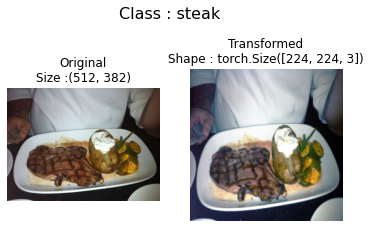

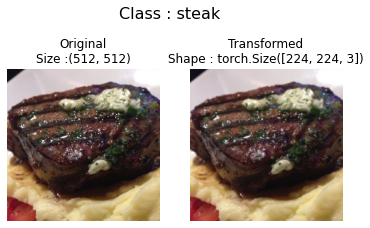

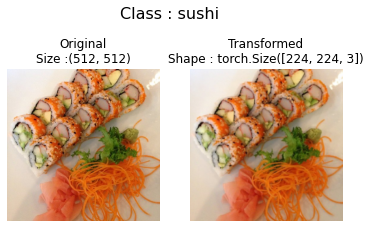

In [35]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

## Model 0: TinyVGG Without data augmentation

Here we go, the fun part :D
Still, data preprocessing is still fun in it's own right, but heeeere we gooo

Let's replicate TinyVGG architecture from the CNN Explainer website

## Creating tranforms and loading data for Model 0

In [36]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [37]:
import os
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform,
                                         target_transform = None
                                         )

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)


# Turn the loaded images into ImageFolder

train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = 32,
                                     shuffle = True,
                                     num_workers = os.cpu_count())

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = 32,
                                    shuffle = False,
                                    num_workers = os.cpu_count())



### Create TinyVGG Model class

Article for the operator fusion part: 
https://horace.io/brrr_intro.html

In [38]:
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self, input_shape : int,
               hidden_units : int,
               output_shape: int) -> None:
               super().__init__()

               self.conv_block_1 = nn.Sequential(
                    nn.Conv2d(in_channels = input_shape,
                             out_channels = hidden_units,
                             kernel_size = 3,
                             stride = 1,
                             padding = 0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels = hidden_units,
                              out_channels = hidden_units,
                              kernel_size = 3,
                              stride = 1,
                              padding = 0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
               )
               self.conv_block_2 = nn.Sequential(
                    nn.Conv2d(in_channels = hidden_units,
                             out_channels = hidden_units,
                             kernel_size = 3,
                             stride = 1,
                             padding = 0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels = hidden_units,
                              out_channels = hidden_units,
                              kernel_size = 3,
                              stride = 1,
                              padding = 0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
               )
               self.classifier_layer = nn.Sequential(
                   nn.Flatten(),
                   nn.Linear(in_features = hidden_units*13*13,
                             out_features = output_shape)
               )
  def forward(self, x : torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_layer(x)
    #print(x.shape)
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x))) Benefits from operator fusion
              

In [39]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3, # number of color channels in our image data
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [40]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))

# Let's do a forward pass for this
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6314e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [41]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from torchinfo import summary
summary(model_0, input_size=(32,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [43]:
import torchmetrics
from torchmetrics.functional import accuracy
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y_logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss} | Train accuracy : {train_acc}")


def test_step(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device : torch.device):
  test_loss, test_acc = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(data_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)
      test_loss += loss_fn(test_pred, y_test).item()
      test_acc += accuracy_fn(test_pred,y_test).item()

  test_loss /= len(data_loader)
  test_acc /= len(data_loader)
  print(f"\nTest loss : {test_loss:.4f}, Test acc: {test_acc:.4f}")


    


In [44]:
# This is daniel's version, but the same results are there:
def train_step_d(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step_d(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    model.to(device)
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step_d(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step_d(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [45]:
from tqdm.auto import tqdm
epochs = 6
torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.003)
for epoch in tqdm(range(epochs)):
  train_step(model = model_0.to(device),
             data_loader = train_dataloader_simple,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy,
             device = device)
  test_step(model = model_0.to(device),
            data_loader = test_dataloader_simple,
            loss_fn = loss_fn,
            accuracy_fn = accuracy,
            device = device)

  0%|          | 0/6 [00:00<?, ?it/s]

Train loss : 1.1073283702135086 | Train accuracy : 0.234375

Test loss : 1.1360, Test acc: 0.2604
Train loss : 1.0821198225021362 | Train accuracy : 0.42578125

Test loss : 1.1469, Test acc: 0.2604
Train loss : 1.087332233786583 | Train accuracy : 0.42578125

Test loss : 1.1532, Test acc: 0.2604
Train loss : 1.0819688737392426 | Train accuracy : 0.453125

Test loss : 1.1363, Test acc: 0.2083
Train loss : 1.0233613029122353 | Train accuracy : 0.49609375

Test loss : 1.1027, Test acc: 0.3428
Train loss : 0.9954635128378868 | Train accuracy : 0.484375

Test loss : 1.3153, Test acc: 0.2708


The results are all over the place for training, as for testing, it's very low meaning that the model has performed very poorly with our dataset

In [46]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3116
Epoch: 2 | train_loss: 1.0995 | train_acc: 0.3320 | test_loss: 1.0699 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0863 | train_acc: 0.4922 | test_loss: 1.0800 | test_acc: 0.5227
Epoch: 4 | train_loss: 1.0826 | train_acc: 0.4102 | test_loss: 1.0599 | test_acc: 0.5729
Epoch: 5 | train_loss: 1.0630 | train_acc: 0.4141 | test_loss: 1.0609 | test_acc: 0.5540
Total training time: 12.881 seconds


### Plot the loss curves of Model 0

A **loss curve** is a way of tracking your mode's progress over time.

In [47]:
# Get the model_O_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [48]:
def plot_loss_curves(results : Dict[str, List[float]]):
  """ Plots training curves of a results dictionary"""
  # Get the loss values of the results dictioonary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary(training and test)
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))
  
  # Setup a plot
  plt.figure(figsize = (15, 7))

  # Plot the loss 
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label="train_acc")
  plt.plot(epochs, test_acc, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

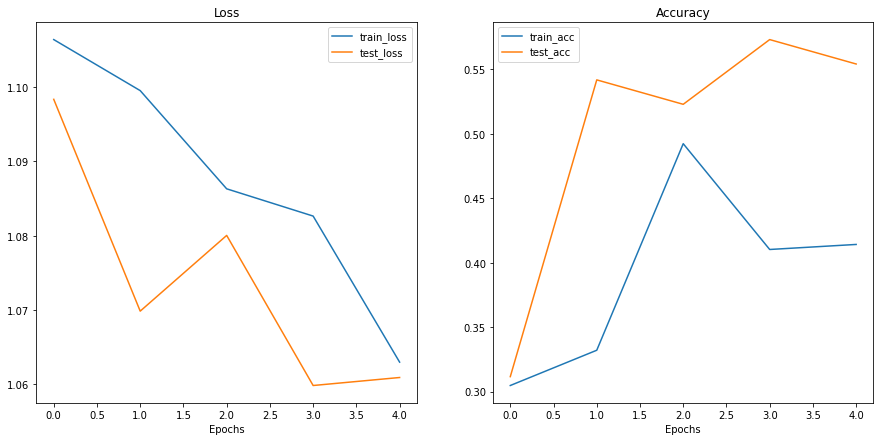

In [49]:
plot_loss_curves(model_0_results)

### Model 1 : TinyVGG with data augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation.




In [50]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

# We don't apply data augmentation on test data since it's only to test our model's ability to learn
test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

### Create train and test dataset and dataloader with data augmentation

In [51]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)

test_data_augmented = datasets.ImageFolder(root = test_dir,
                                           transform = test_transform_simple)

In [52]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)


test_dataloader_augmented = DataLoader(dataset = test_data_simple,
                                       batch_size = BATCH_SIZE,
                                       shuffle = False,
                                       num_workers = NUM_WORKERS)

### Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [53]:
# Create model_1 and send it to the target device

torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes))



Now we've got a model and dataloaders, let's create a loss function and an optimizer and call upon our train function to train and evaluate our model

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_timer = timer()

# Train model
model_1_results = train(model=model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End timer
end_time = timer()
print(f"Total training time for model_1 is : {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1260 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0711 | train_acc: 0.4258 | test_loss: 1.1587 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1252 | train_acc: 0.3047 | test_loss: 1.1587 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1554 | test_acc: 0.3229
Total training time for model_1 is : 26.296 seconds


### Plot the loss curves of model 1

A loss curve helps you evaluate your models performance overtime

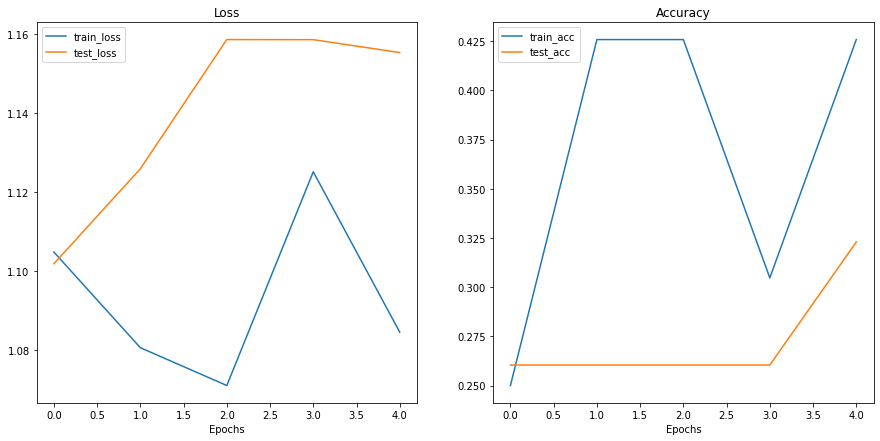

In [55]:
plot_loss_curves(model_1_results)

### Compare model results

After evaluation our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases https://wandb.ai/site
4. MLFlow https://mlflow.org/

In [56]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106342   0.304688   1.098314  0.311553
1    1.099484   0.332031   1.069852  0.541667
2    1.086289   0.492188   1.080026  0.522727
3    1.082625   0.410156   1.059859  0.572917
4    1.063000   0.414062   1.060934  0.553977

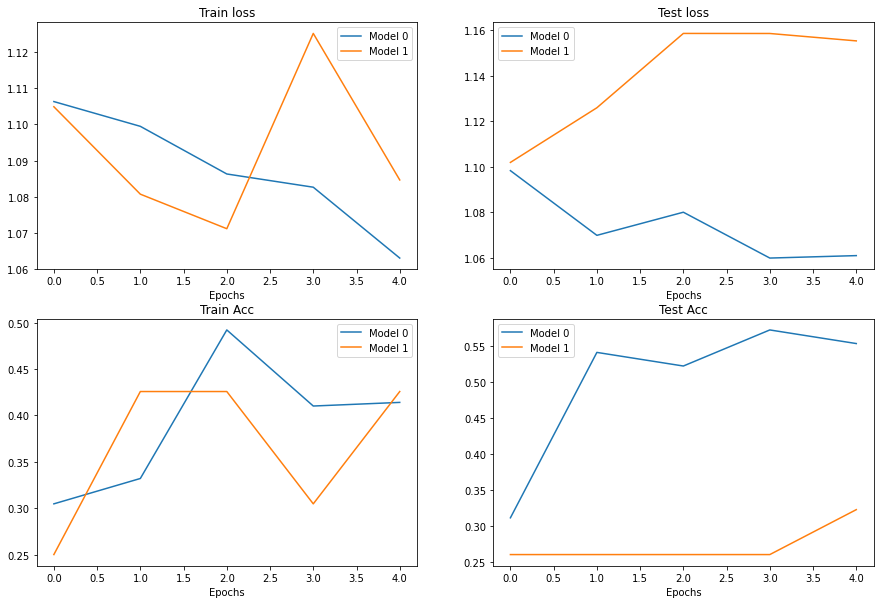

In [57]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get the number of epochs
epochs = range(len(model_0_df))

# Plot the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()


# Plot the test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot the train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()


# Plot the test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

### Making a prediction on a custom image

Although we've trained a model on custom data ... how do you make a prediction on a sample/image that's not in either the training or test dataset

In [58]:
import requests

# Setup custom image path
custom_image_path = data_path/ "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from github, need to use the raw link to download
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path} ...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists ... Skipping download")

### Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.
  .In tensor form with datatype torch.float32
  .Of the shape 64x64x3
  .On the right device.
We can read an image into Pytorch using :
https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html

In [59]:
import torchvision

# Read in custom image (read_image requires string as a path and not PosixPath)
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)) / 255 # We divide by the max number in RGB so that the numbers are between 0 and 1
custom_image_uint8.type(torch.float32)
print(f"Custom image tensor :\n {custom_image_uint8}")
print(f"Custom image shape : {custom_image_uint8.shape}")
print(f"Custom image datatype : {custom_image_uint8.dtype}")

Custom image tensor :
 tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  

In [60]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255.
# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


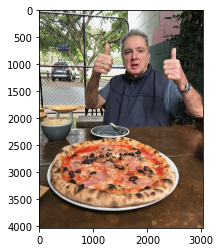

In [61]:
plt.imshow(custom_image.permute(1,2,0))

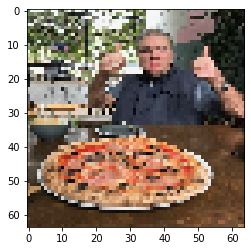

In [62]:
plt.imshow(custom_image_transformed.permute(1,2,0))

### Making a prediction on a custom image with a trained PyTorch model

We need to add a batch size to the image, given that we add a batch dimension to our training and test set.

In [63]:
# Currently, our image has only CHW (color channels, height, width) as it's shape, we need to add the batch size
model_1.eval()
with torch.inference_mode():
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim = 0).to(device)
  custom_image_pred = model_1(custom_image_transformed_with_batch_size).to(device)
custom_image_pred

tensor([[ 0.0716,  0.0484, -0.2086]], device='cuda:0')

**Note**, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size ... (1, 3, 64, 64)
* Make sure the image was on the same device as our model.

In [64]:
print(f"Prediction logits : {custom_image_pred}")
# Convert logits -> prediction  probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)

print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels (put to Cpu as it might cause errors due to class_names)
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim = 1).cpu()
custom_image_pred_label
print(f"Prediction label : {custom_image_pred_label}")

print(f"The prediction is : {class_names[custom_image_pred_label]}")

Prediction logits : tensor([[ 0.0716,  0.0484, -0.2086]], device='cuda:0')
Prediction probabilities: tensor([[0.3659, 0.3575, 0.2765]], device='cuda:0')
Prediction label : tensor([0])
The prediction is : pizza


### Putting custom image prediction together: Building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [65]:
def pred_and_plot_image(model : torch.nn.Module,
                        path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  """ Makes a prediction on a target image with a trained model and plots the image and prediction. """
  # Load the image
  target_image = torchvision.io.read_image(str(path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 225.

  # Transform the data if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) # Make sure the target image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_prob = torch.softmax(target_image_pred, dim = 1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_prob, dim = 1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange the shape
  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob : {target_image_pred_prob.max().cpu():.3f}"
  else:
    title = f"Pred : {target_image_pred_labels} | Prob : {target_image_pred_prob.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


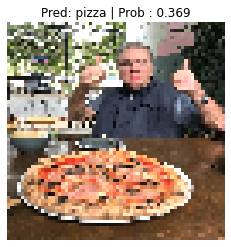

In [66]:
# Pred on our custom image
pred_and_plot_image(model = model_1,
                    path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device=device)

### Using transfer learning and seeing the difference
For this part, we'll basically add a pre-trained model and train it on our dataset and see what the results are.

In [67]:
# Let's set up our manual transform (this is required if torchvision.__version__ < 0.13)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# The normalization values are from the documentation of PyTorch


Why all of these transformations ?

It's simple. We'll be using a pre-trained model and fine-tuning it through training with our custom dataset, meaning, we'll have to prepare our data in the exact same way as the original training data was prepared for the pre-trained model.

In [68]:
# Let's get the pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT means we'll get the best available weights from pretraining on ImageNet

We can see the transforms that were applied on training the model:

In [69]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [70]:
# Setup the model with pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

# The old way to do this would've been : (this is prior to torchvision 0.13)
# model = torchvision.models.efficientnet_b0(pretrained = True).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [71]:
# Let's get a summary of the model using torchinfo
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [72]:
# Before we start with tuning our pre-trained model, we need to freeze the base layers (make them untrainable so it doesn't negatively affect the model's performance)
for param in model.features.parameters():
  param.requires_grad = False

We now modify the model's classifier layer (set the output_shape to 3 rather than 1000)

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace = True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)
).to(device)

In [74]:
# Let's check our modification after freezing and changing the classifier layer
summary(model = model,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Keep in mind, the more trainable parameters a model has, the longer and more power it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quickly. This is one of big benefits of transfer learning, only tweaking the outputs slightly to suit our problem.

In [75]:
# Use ImageFolder to create dataset
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = auto_transforms, # a transform for the data
                                  target_transform = None) # a transfrom for the labels/targets

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = auto_transforms)

# Get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [76]:
train_dataloader = DataLoader(dataset = train_data,
                          batch_size = 32,
                          shuffle = True,
                          num_workers = os.cpu_count())

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = 32,
                             shuffle = False,
                             num_workers = os.cpu_count())

In [77]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [78]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer, 
                loss_fn = loss_fn,
                epochs = 5)

end_time = timer()

print(f"Total training time : {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Total training time : 15.825 seconds


There we go, a model with an accuracy of ~88% in the testing dataset (nearly double what our TinyVGG was able to do).

While it is true that it took quite longer (134 seconds), it's also due to the fact that the training is on the cpu (Using an NVIDIA TITAN RTX GPU, training becomes about ~5 seconds, while the google colab pro version NVIDIA P100 GPU is about 15 seconds of training)

With the google colab free edition, it takes 16 seconds.

## Make a prediction on images from the test set

Let's see how the model performs qualitatively by using some sample images from the testing set (since these aren't seen during training)

Of course, before we start doing that, we'll need to preprocess our images, so we'll need to make sure that:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

To do all of that, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [83]:
from typing import Tuple, List
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model : torch.nn.Module,
                        image_path : str,
                        class_names : List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform : torchvision.transforms = None,
                        device : torch.device = device):
  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for image (if it doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(size = (224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229,0.224, 0.225])
    ])

    ## Predict on image

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image for the batch size ([batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim = 0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification, (sigmoid for normal classification))
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    # 9. Convert prediction probabilites -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred : {class_names[target_image_pred_label]} | Prob : {target_image_pred_probs.max():.3f}")
    plt.axis(False);

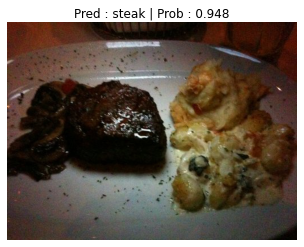

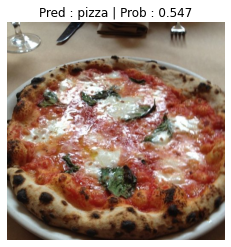

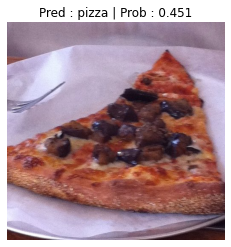

In [84]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list of all image paths from test data
test_image_path_sample = random.sample(population= test_image_path_list,
                                       k = num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path= image_path,
                      class_names = class_names,
                      image_size = (224,224)
                      # transform = weights.transforms() # Pass in a specified transform from our pre-trained model weights
                      )